# HW3-A. Dataset and Dataloader for our HW3

## About this notebook

This notebook was used in the 50.039 Deep Learning course at the Singapore University of Technology and Design.

**Author:** Matthieu DE MARI (matthieu_demari@sutd.edu.sg)

**Version:** 1.0 (06/03/2024)

**Requirements:**
- Python 3
- Matplotlib
- Numpy
- Pandas
- Torch
- Torchmetrics

## 0. Imports and CUDA

In addition to the libraries mentioned above, you will need the *helper_functions.py* file, which contains a few additional functions that help make this notebook simpler for you (e.g. visualisation, test cases, etc.)

Please refrain from modifying said file, but feel free to have a look at it.

In [1]:
# Matplotlib
import matplotlib.pyplot as plt
# Numpy
import numpy as np
# Pandas
import pandas as pd
# Torch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
# Helper functions (additional file)
from helper_functions import *

While not necessary, you might want to run the code for this homework using GPU. It remains possible, however, to use CPU only.

In [2]:
# For windows/linux will try CUDA first, then CPU 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
    
#set default device for following code, so we don't need to specify device every time
torch.set_default_device(device)

cpu


## 1. Loading and visualizing the dataset

We use real London 24hr weather data for our experiments. 
In each file, each row represent an hour, each column is a type of feature of the weather.
We only need the mean temperature for our experiments.

In this first section, we are going to load the dataset from the csv file and explore said dataset. Feel free to have a look at this csv file if you need.
The cells below will define the parameters of our dataset, and load the data from the file.

In [3]:
# Load dataset from file
excel_file_path = 'data/weather_data_1hr.csv'
times, temperatures = load_dataset(excel_file_path)

In [4]:
# Visualize data in arrays
print(times.shape, temperatures.shape)

(1464,) (1464,)


The visualization below shows the samples in the dataset. As you can see, it consists of a time series of some sort, with 1464 time entries.

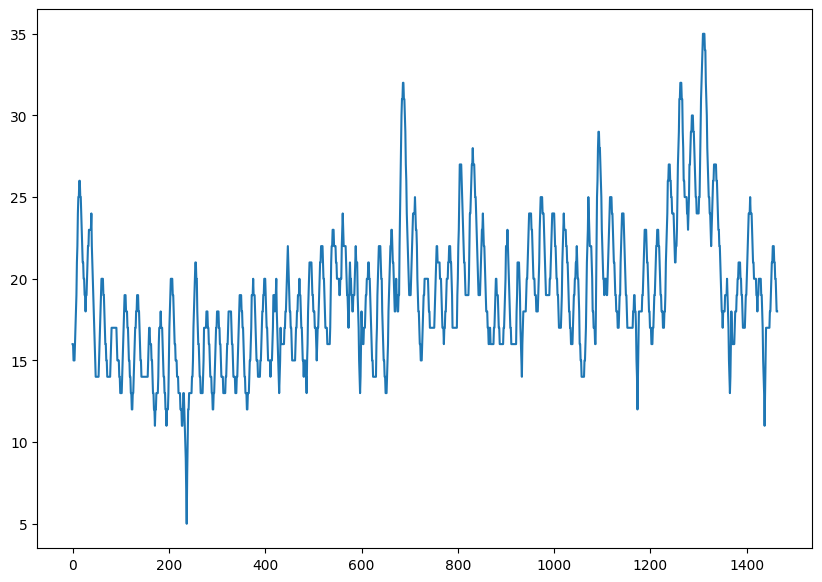

In [5]:
# Visualize the dataset
plot_dataset(times, temperatures)

This dataset, and its curve shown above, consist of temperature observed over time.
We can obtain that there are seasonal features from the plot, which we may utilize to predict temperature.


In this HW, we will attempt to design an AI, which 
- receives as inputs a sequence of 168 values (a week): $ x(t), x(t+1), ..., x(t+167) $, 
- and attempts to predict the next 24 values (a day) , i.e. $ x(t+168), x(t+168+1), ..., x(t+168+23) $.

**Question 1:** By observing the original weather data provided, do you think the AI we will create and whose job will be to predict the next week's weather will generalize well to real-life ? Discuss.

**ANSWER 1:** 
The AI will not generalize well to real-life. Given the small size of the dataset (N=1464), I do not think that there are sufficient data points for the AI to generalize well to real-life. Furthermore, the dataset only accounts for 61 days, which is about 2 months, so it might not be able to capture all the seasons in the year, so can't really predict all weeks in the year. 


## 2. Writing a PyTorch Dataset object

Right now, we would like to write a *PyTorch Dataset* object for our Machine Learning problem.

Have a look at the incomplete code below, you will recognize that there are several None variables (called *None1*, *None2*, etc.). These variables probably need to be replaced with something else.

Your class is expected to have the following features.
- Initialization (__init__ method): The dataset initializes by reading an Excel file (dataset.xlsx) using Pandas read_excel function and stores it in the dataframe attribute.
- Length method (__len__ method): This method should return a certain information about the dataset.
- Get item method (__getitem__ method): This method is called when you index into the dataset (e.g., dataset[idx]).
- There will be an additional method, define_samples(), which will break down the data in the dataset into appropriate chunks.


In [6]:
class CustomDataset(Dataset):
    def __init__(self, times, temperatures, n_inputs, n_outputs):
        self.times = times
        self.temperatures = temperatures
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.inputs = []
        self.outputs = []
        self.define_samples()


    def define_samples(self):
        # Define all inputs
        for i in range(len(self.times) - self.n_inputs - self.n_outputs):
            # Last input not included
            next_input = self.temperatures[i:(i + self.n_inputs)]
            # Output
            next_output = self.temperatures[(i + self.n_inputs):(i + self.n_inputs + self.n_outputs)]
            self.inputs.append(next_input)
            self.outputs.append(next_output)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        # Select samples corresponding to the different inputs
        # and outputs we have created with the define_samples() function,
        # and convert them to PyTorch tensors
        x = torch.tensor(self.inputs[idx], dtype=torch.float32)
        y = torch.tensor(self.outputs[idx], dtype=torch.float32)
        return x, y

We will now create our dataset object, using the pair of values for *n_inputs = 168* and *n_outputs = 24*.

**Question 2:** For this combination of values, how many samples will the dataset contain? You may need to ask your dataset object using a certain operation. 

**ANSWER 2: ** There are 1272 samples. 


In [8]:
# Create our PyTorch Dataset object from the class above
n_inputs = 168
n_outputs = 24
pt_dataset = CustomDataset(times, temperatures, n_inputs, n_outputs)

print(f"number of inputs: {len(pt_dataset.inputs)}")
print(f"number of outputs: {len(pt_dataset.outputs)}")

number of inputs: 1272
number of outputs: 1272


The cell below can be used to visualize the values stored in the tensor with index *idx*. Feel free to experiment with the value of idx.

**Question 3:** Study the code for the Dataset above. How many tensors will be returned when the dataset is summoned using index *t*, by using the operation *dataset[t]* for instance? What will be the shapes of these tensors? If needed, feel free to play with the Dataset object a bit to find your answer. More importantly, what is the information contained in each of these tensors?


**ANSWER 3:**
There are two tensors that will be returned. The size of the input tensor is 168, which corresponds to total number of hours in a week (7 days) before index time, t. The size of the output tensor is 24, which corresponds to the rainfall data for 24 hours (a day) of rainfall data after index time, t. 


torch.Size([168]) torch.Size([24])


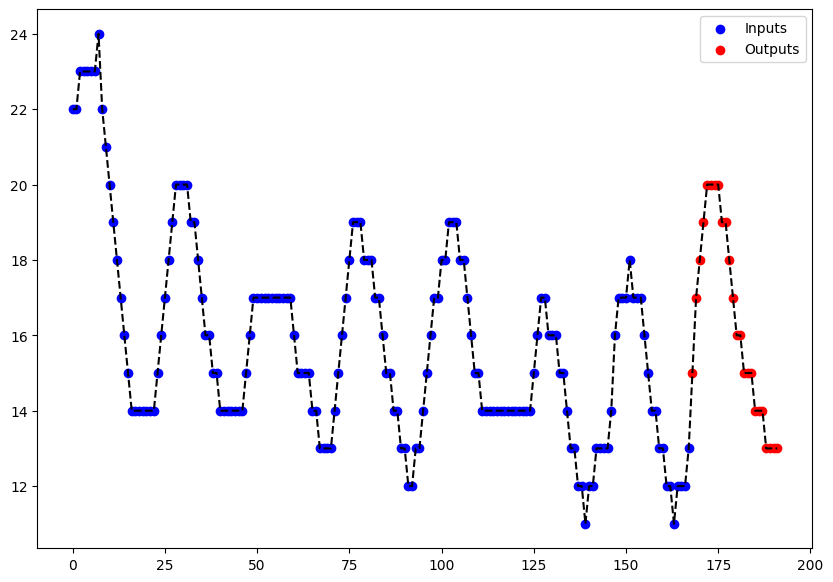

In [9]:
# Testing our dataset object and visualizing data
t = 32
inputs, outputs = pt_dataset[t]
print(inputs.shape, outputs.shape)
visualize_samples(inputs, outputs)

## 3. Writing a Dataloader object

Our next task is now to write a PyTorch dataloader object. It will serve as a conveyor belt for our PyTorch dataset object defined in the previous section.

Its objective will be to form mini-batches of size 128.

**Question 4:** We use mini-batch of size 128. What if we increase the batch size? Talk about the advantages and disadvantages of using a larger batch size.

**ANSWER 4:** 

Advantages of larger batch size: 
1. Given an increase in batch size, our optimizer will use a larger batch size to perform stochastic gradient descent, which likely means better estimation of the MSE loss.
2. With more samples per batch, the computed gradient is a better approximation of the true gradient. It is likely there will be a smoother convergence of the training loss graph. It is likely there are more stable updates, reducing variance in optimization. 

Disadvantages of larger batch size: 
1. A larger batch has a higher memory usage. 
2. With a larger batch size there might be slower convergence. Small batches introduce noise in gradient updates, which can help excape local minima, whereas large batches can get stuch in sharp minima. 



In [11]:
# Define batch size
batch_size = 128

In [12]:
# random number generator
generator = torch.Generator(device=device)

# Create DataLoader object
pt_dataloader = DataLoader(pt_dataset, batch_size = batch_size, shuffle = True, generator = generator)

**Question 5:** If you run the code below, you will get to see the value 10. What does this value 10 correspond to? Please formulate to show how this value is obtained.

**ANSWER 5:** The value 10 corresponds to the number of batches in the Dataloader, i.e. the samples in the dataset are divided into 10 different batches, with each batch ideally the size of 128. Given that there are 1272 samples in the dataset and since we set each batch_size as 128, therefore, 1272/128 = 9.9375 ~= 10 (shown) 
Also, technically, there are 9 full batches of 128 samples, and 1 last batch with 120 samples. 

In [13]:
# Testing our dataloader object
print(len(pt_dataloader))

10


## What is next?

Our task continues in the Notebook 3-B.